In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import seaborn as sns
from random import randint
import numpy as np
from main_data import (
    key_to_camelot,
    open_wheel,
    add_features,
    get_playlist,
    get_friendly,
    pickl,
    unpickl,
    sp,
)


In [ ]:
# %store -r streams_df streams_af_df no_skip_df playlist_af_df
# streams_df, streams_af_df, no_skip_df, playlist_af_df = streams_df, streams_af_df, no_skip_df, playlist_af_df


In [93]:
# Import DataFrames generated by main_data.py
def import_all():
    global all_streams_df, streams_df, streams_af_df, no_skip_df, playlist_af_df, pod_df, wheel_df
    (
        all_streams_df,
        streams_df,
        streams_af_df,
        no_skip_df,
        playlist_af_df,
        pod_df,
        wheel_df,
    ) = unpickl(
        "all_streams_df.p",
        "streams_df.p",
        "streams_af_df.p",
        "no_skip_df.p",
        "playlist_af_df.p",
        "podcasts_df.p",
        "wheel_df.p",
    )
    # return all_streams_df, streams_df, streams_af_df, no_skip_df, playlist_af_df, pod_df, wheel_df = import_all()


def hpm_rollback(pod):
    # refactoring of hpm() that works with pandas 1.4.2
    pod.loc[:, "hours"] = pod.loc[:, "playtime"].copy() / 3600
    pod.index = pod.timestamp
    podm = (
        pod.copy()
        .loc[:, "hours"]
        .resample("M")
        .apply(lambda x: np.sum(x.values))
        .round()
    )
    podm_gb = (
        podm.groupby(podm.index.strftime("%b"))
        .resample("Y")
        .apply(lambda x: np.sum(x.values))
        .round()
        .droplevel(level=1)
    )
    podm_gb = podm_gb.groupby(podm_gb.index).mean()
    return podm_gb


def hpm(df):
    df.loc[:, "hours"] = df.loc[:, "playtime"].copy() / 3600
    df.index = df.timestamp
    dfm = (
        df.copy()
        .resample("M")
        .sum(numeric_only=True)
        .drop(columns=["playtime"])
    )
    dfm_gb = (
        dfm.groupby(dfm.index.strftime("%b"))
        .resample("Y")
        .sum(numeric_only=True)
        .round()
        .droplevel(level=1)
    )
    dfm_gb = dfm_gb.groupby(dfm_gb.index).mean()
    return dfm_gb


def custom_mean(df):
    return df.mean(skipna=True)


def plothpm_rollback(df_gb):
    sns.barplot(data=df_gb.iloc[0:0], x=df_gb.values, y=df_gb.index)


def top_songs(years="all", skips=False, features=True):
    if skips and features:
        df = streams_af_df
    elif not skips:
        df = df.query("(playtime / duration) > 0.51").reset_index()


def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)


In [ ]:
import_all()
all_streams_df


In [ ]:
# all_streams_df.loc[all_streams_df[all_streams_df.timestamp].dt.year == "2020"]
all_streams_df.timestamp.dt.year == 2020
# df["dtime"] = df[["timestamp"]].apply(lambda x: x.dt.time)

# dti = [all_streams_df.timestamp.reset_index(drop=True)]
all_streams_df.set_index(pd.DatetimeIndex(all_streams_df.ddate)).sort_index()


In [ ]:
# I don't recall listening to this artist so much. Investigating if it was on repeat on accident or something.

why_tala = streams_af_df.query('"Hope Tala" in artist')
why_why_tala = (
    why_tala.groupby(by="date")
    .sum(numeric_only=True)
    .sort_values(by="playtime", ascending=False)
)
why_why_tala["playtime"] = why_why_tala["playtime"].apply(lambda x: x / 60000)
why_why_tala.head(50)


In [ ]:
# Looks like I just let her run on most popular song repeat for a few hours.
streams_af_df.query('date == "11/27/2019"').sort_values(by="timestamp")


In [ ]:
no_skip_df.query('artist.str.contains("(?i)miles davis")', engine="python")


In [ ]:
pivot_track = pd.DataFrame(
    no_skip_df.query('year == "2022"')
    .pivot_table(columns=["artist", "track", "year"], aggfunc="size")
    .sort_values(ascending=False)
)

pivot_track.head(30)


In [ ]:
no_skip_df.query('year == "2022"')


In [ ]:
# # Check for tracks missing from new df
# series1 = duration_prep['spotify_track_uri']
# series2 = local_features['uri']
# comparison = series1[~series1.isin(series2)]
# comparison


In [ ]:
# # Show missing track URLs for further investigation; track is likely removed or yet to be analyzed for audio_features.
# missing_tracks = []
# for i in range(len(comparison)):
#     missing_tracks.append(sp.track(comparison.iloc[i])['external_urls'])
# missing_tracks


In [ ]:
# Most played tracks
pivot_track = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist", "track"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_track


In [ ]:
# Most listened to artists by number of songs played
pivot_artist = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_artist


In [ ]:
miles = no_skip_df.query('artist.str.contains("(?i)Miles Davis")')
pivot_miles = pd.pivot_table(miles, values="playtime", index=["album"], aggfunc="sum")
pivot_miles = pivot_miles.sort_values(by="playtime", ascending=False)
miles


In [ ]:
pivot_album_time = pd.pivot_table(
    no_skip_df, values="playtime", index=["album"], aggfunc="sum"
)


In [ ]:
pivot_album_time = pivot_album_time.sort_values(by="playtime", ascending=False)
pivot_album_time.head(20)


In [ ]:
pivot_artist_time = pd.pivot_table(
    no_skip_df, values="playtime", index=["artist"], aggfunc="sum"
)


In [ ]:
# print(pivot_artist_time.sort_values().to_string())
artist_time = pivot_artist_time.sort_values(
    by="playtime", ascending=False
).reset_index()
print(artist_time.to_string())


In [ ]:
# Artists played more than 10 mins
repeated_artists = artist_time[:1750]
# Number of unique tracks played from those artists

len(streams_af_df["track"].unique())


In [ ]:
still_repeated = repeated_artists["artist"]


In [ ]:
# Count number of unique tracks per artist and create ascending list
still_still_repeated = no_skip_df.query("artist in @still_repeated")
# still_still_repeated.loc[:, 'artist'] = still_still_repeated.copy().loc[:, 'artist'].astype(str)
group = still_still_repeated.groupby("artist")
songs_per_artist = group.apply(lambda x: x["track"].unique())
unique_songs = songs_per_artist.reset_index(name="unique_titles")


In [ ]:
unique_songs["unique_count"] = unique_songs.iloc[:, 1].str.len()


In [ ]:
unique_songs = unique_songs.sort_values(by="unique_count").reset_index()


In [59]:
unique_songs

,index,artist,unique_titles,unique_count
0,379,DJ Lewi,[Ricky],1
1,1348,SHERELLE,[160 DOWN THE A406],1
2,1349,SHXCXCHCXSH,[This Hmming Raverie],1
3,1352,SONIKKU,[Sweat - SOPHIE Remix],1
4,302,Charlie Heat,[ANGRY HEARTS],1
...,...,...,...,...
1745,1599,Tim Hecker,"[Into the void, The Piano Drop, I'm Transmitti...",110
1746,104,Aphex Twin,"[Petiatil Cx Htdui, Ziggomatic 17, #15, Tha, P...",113
1747,1579,The Roots,"[You Got Me - Drum & Bass Mix, In Love With Th...",117
1748,986,Ludwig van Beethoven,"[Piano Sonata No. 8 in C Minor, Op. 13 ""Pathét...",127


In [ ]:
unique_export = unique_songs.query("unique_count <= 8")["artist"]


In [ ]:
pivot_artist_time.playtime


In [ ]:
# Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should explore more of.
pivot_artist_time.query("playtime > 3600000").query("artist in @unique_export")


Todo: Next step after the above is to plot least uniques with most ms played

In [ ]:
# Convert
pivot_artist_time["playtime"] = pd.to_timedelta(pivot_artist_time.playtime, unit="ms")


In [ ]:
pivot_artist_time["playtime"] = pivot_artist_time["playtime"].apply(format_td)


In [ ]:
# Show longest songs
no_skip_df.copy().sort_values(by="playtime", axis=0, ascending=False)


In [ ]:
# How to control this for missing months? do october 25 2019 thru 2022
sns_prep = streams_af_df.query('year == "2019"| year == "2020" | year == "2021"')
sns_prep = pd.pivot_table(
    sns_prep,
    values="playtime",
    index=["month"],
    aggfunc="sum",
).reset_index()
sns_prep["hours played"] = sns_prep["playtime"].apply(lambda x: x / 3600000)
sns.barplot(data=sns_prep, x="month", y="hours played")


In [ ]:
# sum of unique uris closely maps to total skips per month
sns_prep = streams_af_df.copy().drop_duplicates(subset="id")
sns_prep["count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [ ]:
# good way to find months with most music discovery along with unique URIs
sns_prep = streams_af_df.copy().query("(playtime / duration) < 0.25")
sns_prep.at[:, "count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [ ]:
# common keys of listened tracks
no_skip_df.loc[:, "timestamp"] = no_skip_df.loc[:, "timestamp"].astype(str)
pivot_track = pd.DataFrame(
    no_skip_df.drop_duplicates(subset="timestamp")
    .pivot_table(columns=["key_signature"], aggfunc="size")
    .sort_values(ascending=False)
)
pivot_track


In [ ]:
# # This version works with uri
# #should also have function to get uri from song title + artist
# #todo: proper type hinting and default values
# # separate functions i suppose, maybe with decorators
# # https://stackoverflow.com/questions/62153371/best-way-to-create-python-function-with-multiple-options


get_friendly(
    streams_af_df, tempo_range=10, uri="5jh3f8fy8a335XYDyJ7x9R", shift=["all"]
).sort_values(by="track")


In [ ]:
# How often do I play songs with "birthday" in the name on my loved ones' birthdays?
streams_af_df.query("(playtime / duration) > 0.1").query(
    "track.str.contains('(?i)birthday')"
).sort_values(by=["month", "date"])


In [ ]:
# Todo: plot podcast listening vs music listening
# Totals per month
podcasts_2020 = pod_df.copy()
podcasts_2020["playtime"] = podcasts_2020["playtime"].copy() / 3600
podcast_per_month = podcasts_2020.groupby(by="month").sum(numeric_only=True)
podcast_per_month["playtime"]
sns.barplot(
    data=podcast_per_month, x=podcast_per_month["playtime"], y=podcast_per_month.index
)


In [ ]:
streams_af_df.query("duration < playtime").index


In [ ]:
# import_all()
# Todo: figure out which level of this
pod = pod_df.copy()
pod.loc[:, "hours"] = pod_df.loc[:, "playtime"].copy() / 3600
pod.index = pod.timestamp
podm = (
    pod.copy().loc[:, "hours"].resample("M").apply(lambda x: np.sum(x.values)).round()
)
podm_gb = (
    podm.groupby(podm.index.strftime("%b"))
    .resample("Y")
    .apply(lambda x: np.sum(x.values))
    .round()
    .droplevel(level=1)
)
podm_gb = podm_gb.groupby(podm_gb.index).mean()
podm_gb


In [83]:
podm = streams_df


<AxesSubplot: xlabel='hours', ylabel='timestamp'>

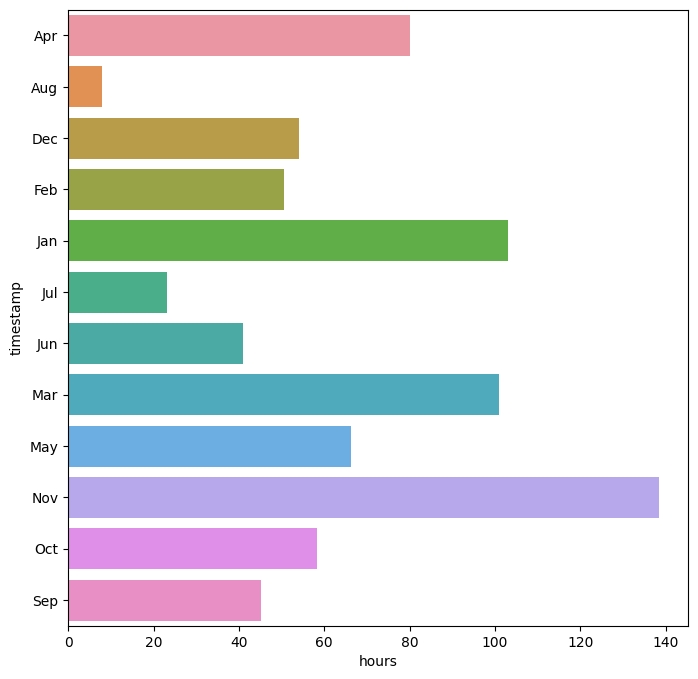

In [95]:
# avg per month

import matplotlib as plt
podm_gb = hpm(pod_df)
plt.rcParams["figure.figsize"] = (8, 8)
sns.barplot(data=podm_gb, x=podm_gb["hours"], y=podm_gb.index)


In [ ]:
podm_gb


In [72]:
# streams_dupe = streams_df.copy().drop_duplicates
streams_df.copy().drop_duplicates(subset='a').drop(columns=['end', 'shuffle', 'id', 'ddate', 'dtime', 'date']).query('artist.str.contains("(?i)paul")')

,timestamp,playtime,track,artist,album,start,time,month,year,day
128,2019-10-02 16:00:58+00:00,275,Do You Love Her Now,Jai Paul,Do You Love Her Now / He,clickrow,16:00:58,Oct,2019,Wed
507,2022-02-20 09:23:14+00:00,4,Nita,Paul Chambers,Whims Of Chambers,fwdbtn,09:23:14,Feb,2022,Sun
2504,2022-02-20 11:34:26+00:00,20,Casino,Paul Motian,Lost In A Dream,clickrow,11:34:26,Feb,2022,Sun
3835,2022-09-02 04:35:00+00:00,4,Kralle,Paula Temple,ETXC001-004,fwdbtn,04:35:00,Sep,2022,Fri
4991,2021-08-09 08:15:15+00:00,51,Popmaster Intro,Prince Paul,Politics Of The Business,trackdone,08:15:15,Aug,2021,Mon
6626,2022-03-10 11:29:06+00:00,86,Caravan,Paulo Moura,Fruto Maduro,trackdone,11:29:06,Mar,2022,Thu
7631,2022-02-14 08:35:42+00:00,155,Spanish Fly,Paul Jacobs,Spanish Fly,trackdone,08:35:42,Feb,2022,Mon
8938,2022-02-20 11:39:03+00:00,10,Gumshoe Blues,Paul Pritchard,Film Noir,clickrow,11:39:03,Feb,2022,Sun
9470,2019-11-01 03:07:57+00:00,175,Someday I'll Know,Paul Grant,Beginnings / Someday I'll Know,trackdone,03:07:57,Nov,2019,Fri
10134,2022-02-08 21:52:04+00:00,85,Heaven,Paul Raffaele,"Hot Sense Splits, Vol. 2",clickrow,21:52:04,Feb,2022,Tue
